Recommendation system requires training with each new items/user on our platform, so it's reasonable to make a continues training pipleline "Kubeflow".

# Setting Up GCP

## Setting global variables

In [111]:
import config

In [112]:
# Put the project id here
PROJECT_ID = !(gcloud config get-value core/project) #Get's the latest project to your account
print(f"Your project id is: {PROJECT_ID}")
PROJECT_ID = PROJECT_ID[0]
REGION = 'us-central1' # Define your zone here
BUCKET = 'gs://' + PROJECT_ID # Our bucket, feel free to change it as fits to your project
DATA_PATH = BUCKET+"/"+config.TRAIN_DATA_PATH
EPOCHS = config.EPOCHS
MODELS_OUTPUT_PATH = BUCKET + '/Rec-Anime/models/tf'

Your project id is: ['articulate-run-367808']


Exporting our variable to cloud environment variable

In [113]:
%env DATA_PATH={DATA_PATH}
%env EPOCHS={EPOCHS}
%env REGION={REGION}
%env MODELS_OUTPUT_PATH={MODELS_OUTPUT_PATH}


env: DATA_PATH=gs://articulate-run-367808/Data
env: EPOCHS=150
env: REGION=us-central1
env: MODELS_OUTPUT_PATH=gs://articulate-run-367808/Rec-Anime/models/tf


Excute next cell if you didn't make your bucker yet

In [6]:
!gsutil mb -p $PROJECT_ID gs://$PROJECT_ID
!gsutil acl ch -u AllUsers:R gs://$PROJECT_ID

Creating gs://articulate-run-367808/...
Updated ACL on gs://articulate-run-367808/


In [7]:
print(f"Your Bucket: {BUCKET}")

Your Bucket: gs://articulate-run-367808


# Downloading Data from Kaggle

In [9]:
! pip install kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 2.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=6c6ffa5fa50987ee8bdc477ea995c189be84f0bcf3a21aa75ef9b739b6361a1b
  Stored in directory: /home/jupyter/.cache/pip/wheels/11/ec/8f/80c32ff2501f7b1a76f4df651a0242314d229a5d3e5130bd01
Successfully built kaggle


In [14]:
! cp kaggle.json /home/jupyter/.kaggle

In [29]:
!mkdir -p $DATA_PATH
!echo $DATA_PATH

gs://articulate-run-367808/Data


In [35]:
!kaggle datasets download -d hernan4444/anime-recommendation-database-2020

anime-recommendation-database-2020.zip: Skipping, found more recently modified local copy (use --force to force download)


In [56]:
!gsutil cp anime-recommendation-database-2020.zip $DATA_PATH/ #Can't unzip files in storage bucket / must be unzipped in cloud shell first

Copying file://anime-recommendation-database-2020.zip [Content-Type=application/zip]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][660.8 MiB/660.8 MiB]                                                
Operation completed over 1 objects/660.8 MiB.                                    


PRIOR TO STARTING THE LAB: Make sure you create a new instance with AI Platform Pipelines. Once the GKE cluster is spun up, copy the endpoint because you will need it in this lab.

To get our endpoint, go to AI Platform/Pipelines and withing your pipeline setting you will find the endpoint host

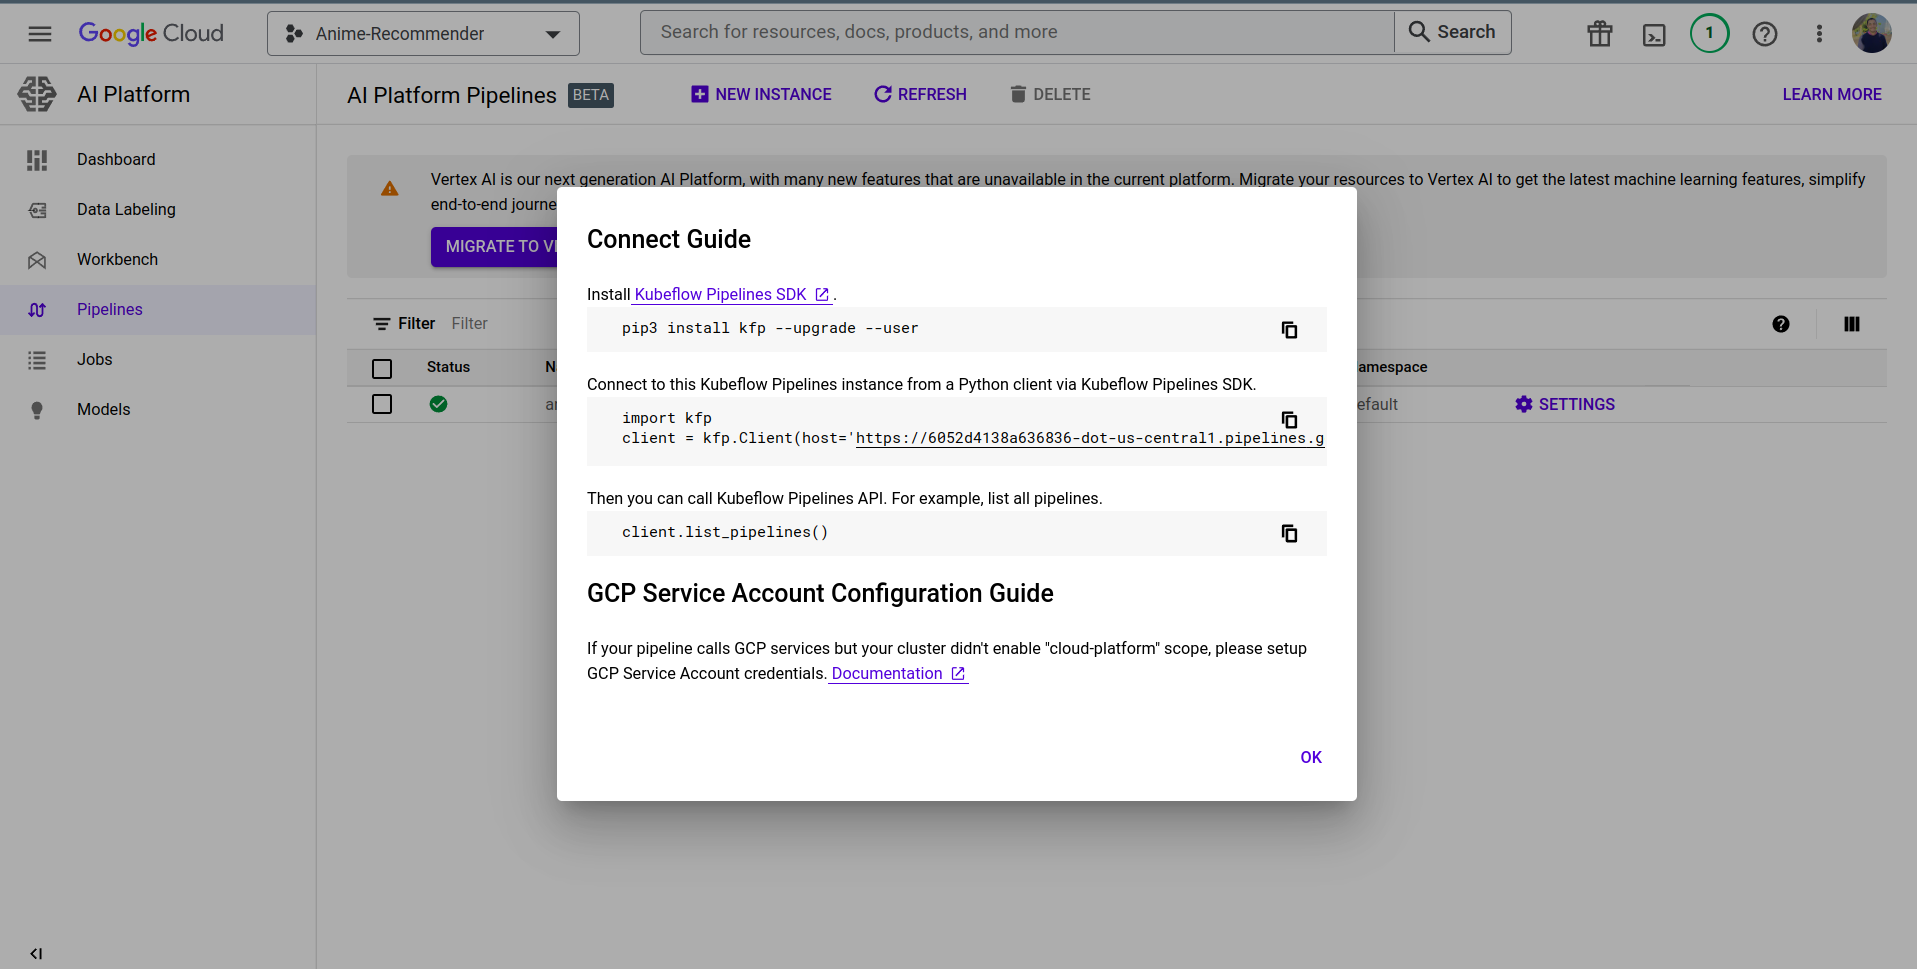

In [228]:
ENDPOINT = "https://6052d4138a636836-dot-us-central1.pipelines.googleusercontent.com" #Your cluster endpoint #GKE host url
PIPELINE_NAME = "Rec_Anime_NNFC_TF"

In [229]:
%env ENDPOINT={ENDPOINT}
%env PIPELINE_NAME={PIPELINE_NAME}

env: ENDPOINT=https://6052d4138a636836-dot-us-central1.pipelines.googleusercontent.com
env: PIPELINE_NAME=Rec_Anime_NNFC_TF


We must make sure all apis are enabled, run the next cell to enable it. "We can run it in cloud shell as well."

In [115]:
%%bash
gcloud services enable \
  serviceusage.googleapis.com \
  compute.googleapis.com \
  container.googleapis.com \
  iam.googleapis.com \
  servicemanagement.googleapis.com \
  cloudresourcemanager.googleapis.com \
  ml.googleapis.com \
  iap.googleapis.com \
  sqladmin.googleapis.com \
  meshconfig.googleapis.com \
  krmapihosting.googleapis.com \
  servicecontrol.googleapis.com \
  endpoints.googleapis.com \
  cloudbuild.googleapis.com

Operation "operations/acf.p2-700083308306-1a2345cb-6036-4bc0-b397-bad4fb6ed936" finished successfully.


With Anthos Service Mesh, you get an Anthos tested and supported distribution of Istio, letting you create and deploy a service mesh on GKE on Google Cloud and other platforms with full Google support. "Needed for Google Kubernetes Engine"

# Training Script

We will define our training script here

In production it will be different with BigQuery but the conceopts are the same

In [132]:
import os
train_script_dir = "nnfc" # Our training scripts will be saved in this directory
if not os.path.exists(train_script_dir): 
    os.makedirs(train_script_dir)

In [133]:
%%writefile ./nnfc/train.py

import fire
import pandas as pd
import os
import config
from Utils.data.preprocess import preprocessor_anime_data,preprocess_colabritive
from train.colabritive_system import NNCollaborativeFiltering
import pickle
import subprocess

def save_model(save_dir,model,save_tf: bool=True):
    """args:
            save_dir: The model registry path to save the model.
            model: The trained model we want to save.
            save_tf: if True save it in tensorflow formate, otherwise saves it as picke.
    """

    model_name = os.path.join("save_dir","anime_recommender")
    if save_tf:
        model.save(f"{model_name}.h5")
    else:
        with open(model_name, 'wb') as model_file:
        pickle.dump(model, f"{model_name}.pkl")

def train(training_dataset_path,output_dir,epochs):
    path_anime = os.path.join(training_dataset_path, "anime.csv")
    path_anime_list = os.path.join(training_dataset_path, "animelist.csv")

    # I want to test on user_id 0
    r_anime = pd.read_csv(path_anime,low_memory=True) # THat's the maximum for that

    anime_data = preprocessor_anime_data(r_anime).get_transformed_data()
    # Data behave differently when loading next row
    prepro_nnfc_class = preprocess_colabritive(path_anime_list,load_rows=88) # That's why SQL is important

    x_user,x_item,y = prepro_nnfc_class.get_x_y_data_NNCF(my_class.get_users_for_item(),anime_data)
    n_users,n_items = prepro_nnfc_class.get_num_user_items()

    model = NNCollaborativeFiltering(n_users=n_users, n_items=n_items)
    history,model = model.train_model(x_user,x_item,y,epochs=epochs,embedding_dims=10, d_layers=[10]) # The rest of training params could be added in func param as well
    
    save_model(output_dir,model,True)


if __name__ == '__main__':
    fire.Fire(train)

Writing ./nnfc/train.py


In [151]:
!cp -r Utils/ nnfc/
!cp -r train/ nnfc/

In [156]:
%%writefile ./nnfc/Dockerfile

FROM gcr.io/deeplearning-platform-release/base-cpu
RUN pip install -U fire tensorflow==2.10 pandas scikit-learn
WORKDIR /app
COPY train.py .
COPY Utils/ .
COPY train/ .

ENTRYPOINT ["python", "train.py"]

Overwriting ./nnfc/Dockerfile


In [157]:
RECOM_NNFC_IMAGE_NAME='nnfc'
RECOM_NNFC_IMAGE_TAG='latest'
RECOM_NNFC_IMAGE_URI=f'gcr.io/{PROJECT_ID}/{RECOM_NNFC_IMAGE_NAME}:{RECOM_NNFC_IMAGE_TAG}'
print(RECOM_NNFC_IMAGE_URI)

gcr.io/articulate-run-367808/nnfc:latest


In [158]:
!gcloud builds submit --tag $RECOM_NNFC_IMAGE_URI $RECOM_NNFC_IMAGE_NAME

Creating temporary tarball archive of 20 file(s) totalling 222.1 KiB before compression.
Uploading tarball of [nnfc] to [gs://articulate-run-367808_cloudbuild/source/1667730951.392487-3290b4645a6e4426b815dc0b7d5e86fa.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/articulate-run-367808/locations/global/builds/fca047d3-8411-433e-8b1d-6165f9756374].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/fca047d3-8411-433e-8b1d-6165f9756374?project=700083308306 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "fca047d3-8411-433e-8b1d-6165f9756374"

FETCHSOURCE
Fetching storage object: gs://articulate-run-367808_cloudbuild/source/1667730951.392487-3290b4645a6e4426b815dc0b7d5e86fa.tgz#1667730951688272
Copying gs://articulate-run-367808_cloudbuild/source/1667730951.392487-3290b4645a6e4426b815dc0b7d5e86fa.tgz#1667730951688272...
/ [1 files][ 56.3 KiB/ 56.3 KiB]                                                
Op

# Pipeline script

In [164]:
!mkdir ./pipeline

mkdir: cannot create directory ‘./pipeline’: File exists


In [210]:
%%writefile ./pipeline/recom_anime_tf_pipeline.py
import os
import kfp
from kfp.dsl.types import GCPProjectID
from kfp.dsl.types import GCPRegion
from kfp.dsl.types import GCSPath
from kfp.dsl.types import String
from kfp.gcp import use_gcp_secret
import kfp.dsl as dsl
import kfp.gcp as gcp

TF_TRAINER_IMAGE = os.getenv('TF_TRAINER_IMAGE')
BUCKET = os.getenv('BUCKET')
DATA_PATH = os.getenv('DATA_PATH')
REGION = os.getenv('REGION')
EPOCHS = os.getenv('EPOCHS')
MODELS_OUTPUT_PATH = os.getenv('MODELS_OUTPUT_PATH')

COMPONENT_URL_SEARCH_PREFIX = 'https://raw.githubusercontent.com/kubeflow/pipelines/0.2.5/components/gcp/'

# Create component factories
component_store = kfp.components.ComponentStore(
    local_search_paths=None, url_search_prefixes=[COMPONENT_URL_SEARCH_PREFIX])

# Load BigQuery and AI Platform Training op
mlengine_train_op = component_store.load_component('ml_engine/train')

@dsl.pipeline(
    name='Recom_Anime_NNFC_Pipeline',
    description='Pipeline continuesly train recommender system for animes, NNFC model'
)
def pipeline(
    project_id,
    region='us-central1'
):

    
    # Training arguments to be passed to the TF Trainer
    tf_args = [
        '--training_dataset_path', DATA_PATH,
        '--output_dir', MODELS_OUTPUT_PATH,
        '--epochs', EPOCHS,
    ]
    
    
    # AI Platform Training Jobs with trainer images 
    train_tf = mlengine_train_op(
        project_id=project_id,
        region=region,
        master_image_uri=TF_TRAINER_IMAGE,
        args=tf_args).set_display_name('Tensorflow Anime Recommender NNFC Model - AI Platform Training')

Overwriting ./pipeline/recom_anime_tf_pipeline.py


In [211]:
TAG = 'latest'
TF_TRAINER_IMAGE = f'gcr.io/{PROJECT_ID}/recom_anime_tf_pipeline:{TAG}'

In [212]:
%env TF_TRAINER_IMAGE={TF_TRAINER_IMAGE}

env: TF_TRAINER_IMAGE=gcr.io/articulate-run-367808/recom_anime_tf_pipeline:latest


In [213]:
!echo $TF_TRAINER_IMAGE

gcr.io/articulate-run-367808/recom_anime_tf_pipeline:latest


# Compile Pipeline

Compile the pipeline

If didn't install Kubeflow SDK uncomment the following cell

In [214]:
#!pip3 install kfp --upgrade

In [215]:
!dsl-compile --py pipeline/recom_anime_tf_pipeline.py --output recom_anime_tf_pipeline.yaml

/opt/conda/lib/python3.7/site-packages/kfp/components/_components.py:201: FutureWarning: Container component must specify command to be compatible with KFP v2 compatible mode and emissary executor, which will be the default executor for KFP v2.https://www.kubeflow.org/docs/components/pipelines/installation/choose-executor/
  category=FutureWarning,


In [216]:
!head recom_anime_tf_pipeline.yaml

apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  generateName: recom-anime-nnfc-pipeline-
  annotations: {pipelines.kubeflow.org/kfp_sdk_version: 1.8.14, pipelines.kubeflow.org/pipeline_compilation_time: '2022-11-06T11:49:44.363195',
    pipelines.kubeflow.org/pipeline_spec: '{"description": "Pipeline continuesly train
      recommender system for animes, NNFC model", "inputs": [{"name": "project_id"},
      {"default": "us-central1", "name": "region", "optional": true}], "name": "Recom_Anime_NNFC_Pipeline"}'}
  labels: {pipelines.kubeflow.org/kfp_sdk_version: 1.8.14}
spec:


In [217]:
!sed -i 's/\"command\": \[\]/\"command\": \[python, -u, -m, kfp_component.launcher\]/g' recom_anime_tf_pipeline.yaml


In [218]:
!cat recom_anime_tf_pipeline.yaml | grep "component.launcher"


In [230]:
!echo $ENDPOINT

https://6052d4138a636836-dot-us-central1.pipelines.googleusercontent.com


In [231]:
%%bash
kfp --endpoint $ENDPOINT pipeline upload \
-p $PIPELINE_NAME \
./recom_anime_tf_pipeline.yaml

Pipeline Details
------------------
Pipeline ID  cb0f2866-d131-47e0-ac61-2b40b79df3f0
Name         Rec_Anime_NNFC_TF
Description
Uploaded at  2022-11-06T11:52:07+00:00
Version ID   cb0f2866-d131-47e0-ac61-2b40b79df3f0
+------------------+-----------------+
| Parameter Name   | Default Value   |
+==================+=================+
| project_id       |                 |
+------------------+-----------------+
| region           | us-central1     |
+------------------+-----------------+


You can start the run from pipelines and configure your recurring runs, every hour? every week? what are your maximum runs to retrain your model?

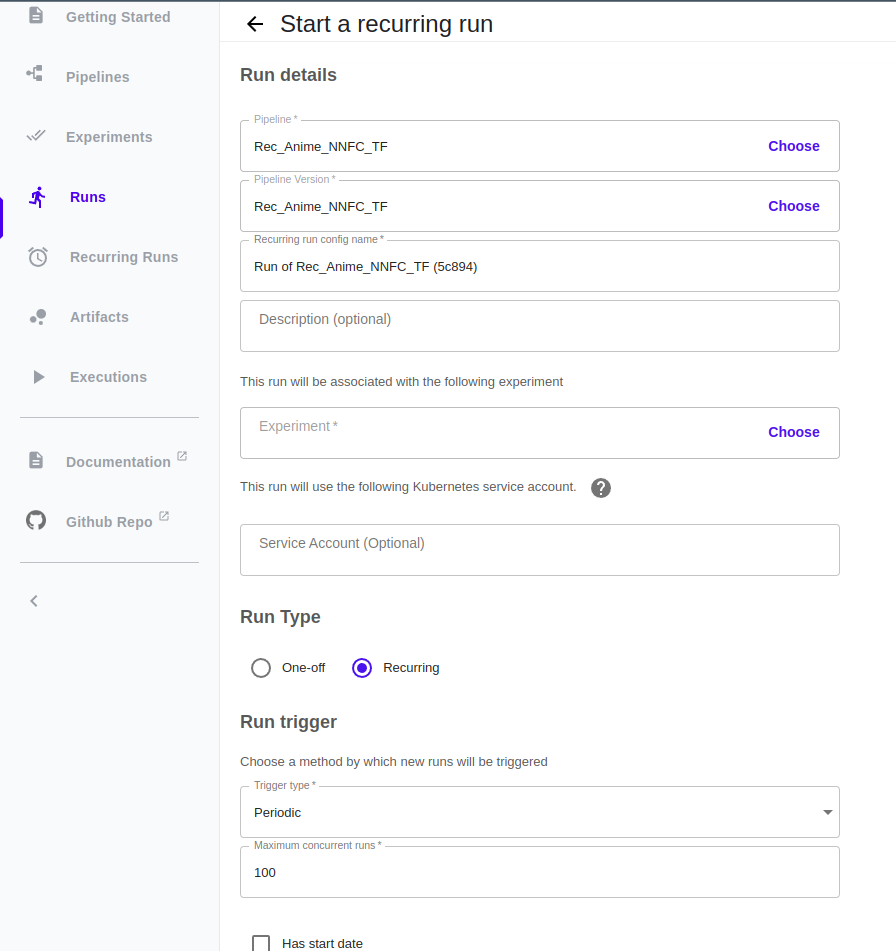

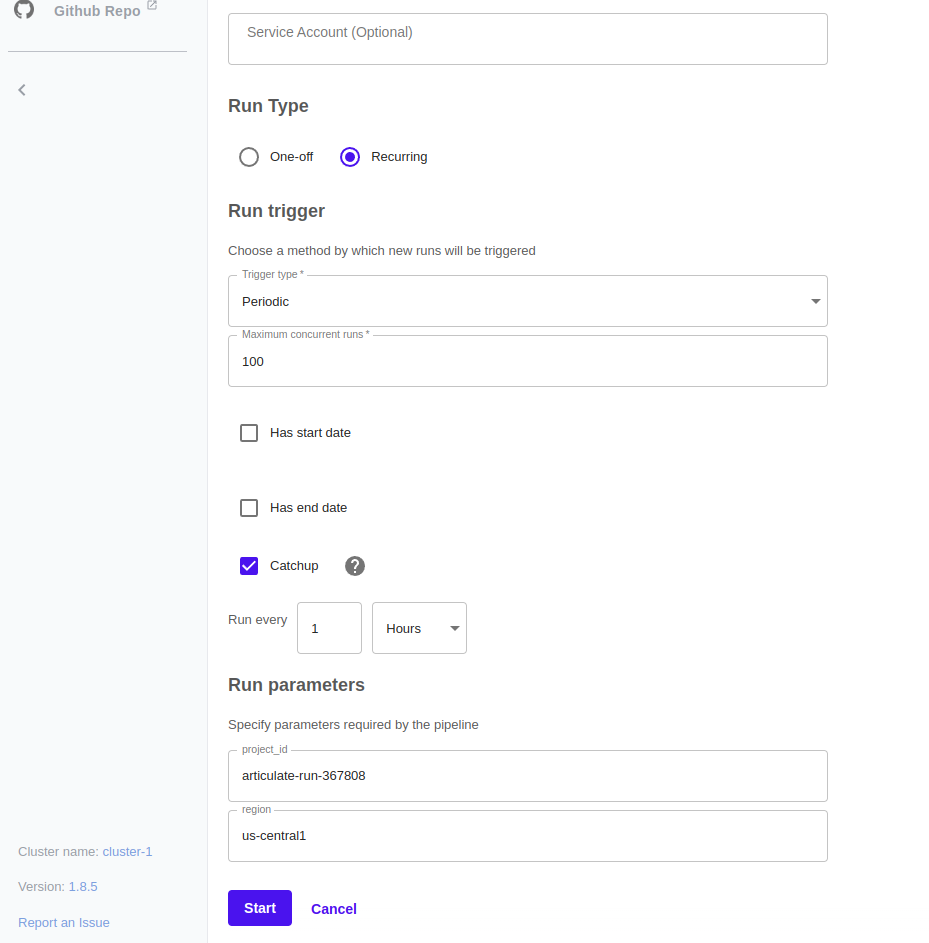